# Data Science | Lab: Natural Language Processing
**Table of Contents:**  <a name="toc"></a>
1. [Accessing Websites](#crwaling)
2. [Vectorizing Text](#vect)
3. [Document Classification](#classification)

## Accessing Websites <a name="crawling"></a>

For this lab, we will rely on[requests](https://docs.python-requests.org/en/latest/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to help us access text data from weg pages.
The following is a short glossary explaining some common terms used when collecting data:
- **Crawler** Finding and downloading web pages automatically is called crawling. A program that
downloads pages is called a web crawler.
- **Parser** Interpreting and reconstructing the structure of a website is called parsing.
- **Scraper** Extracting the content of a website (text only) is called scraping.

In addition, [boilerpipe](https://pypi.org/project/boilerpy3/) can be used to automatically remove the boilerplate.

<div class="alert alert-block alert-info">
    <b>Politeness</b></br>
    Be polite when crawling web pages! Do not fetch more than one page at a time from a particular web server. Wait in between requests. Respect the <tt>robots.txt</tt> file if provided.
</div>

[Back to top](#toc)

In [85]:
import requests  # crawling
from bs4 import BeautifulSoup  # parsing, scraping
import pandas as pd
import os
import time

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# importing NearestCentoird from sklearn
from sklearn.neighbors import NearestCentroid

# import confusion matrix
from sklearn.metrics import confusion_matrix

# import KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier

# importing train_test_split
from sklearn.model_selection import train_test_split

# GridSearch imports
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import re
import re

### Constructing the News Article Dataset
The following code is used to read and store all links and headers of articles categorized under the topics *artificial intelligence* and *neuroscience* from [Wired UK](https://www.wired.co.uk).

``build_dataset()`` takes a ``seed_url`` (topic overview page) as its sole argument and stores an article's header, its link and associated topic in a dataframe.

In [2]:
def build_dataset(seed_url):
    articles = {
        'topic': [],
        'link': [],
        'header': [],
    }
    data = requests.get(seed_url)
    time.sleep(1) # sleeping for 1 second to make sure we are polite!
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )
    candidates = soup.find_all(
        "a",
        class_=[
            "summary-item-tracking__hed-link",
            "summary-item__hed-link",
        ],
    )
    for article in candidates:
        articles['topic'].append(seed_url.split('/')[-1])
        articles['link'].append(article['href'])
        articles['header'].append(article.get_text().strip())

    return pd.DataFrame(articles)

<div class="alert alert-block alert-info">
    <b>Caution:</b> Instead of crawling the webpage multiple times, use locally stored data!
</div>

In [3]:
seed_url = 'https://www.wired.co.uk/topic/'
# We only want to crawl the web if absolutely necessary, so we check first if we already have an article_headers.csv in our directory
if os.path.exists('article_headers.csv'):
    df = pd.read_csv(
        'article_headers.csv',
        sep='\t',
    )
    print('read articles from file')
else:
    print('crawling articles from web...')
    # Crawl and parse the AI page
    df = build_dataset(seed_url + 'artificial-intelligence')

    # Crawl and parse the neuroscience page
    df_ns = build_dataset(seed_url + 'neuroscience')

    df = pd.concat(
        [
            df,
            df_ns
        ],
        ignore_index=True,
    )
    df.to_csv(
        'article_headers.csv',
        sep='\t',
        index=False,
    )

read articles from file


In [4]:
display(df.head())
display(df.tail())

,topic,link,header
0,artificial-intelligence,/story/why-beating-china-in-ai-brings-its-own-...,Why ‘Beating China’ in AI Brings Its Own Risks
1,artificial-intelligence,/story/botto-the-millionaire-ai-artist-is-gett...,"Botto, the Millionaire AI Artist, Is Getting a..."
2,artificial-intelligence,/story/onlyfans-models-are-using-ai-impersonat...,OnlyFans Models Are Using AI Impersonators to ...
3,artificial-intelligence,/story/celsius-founder-alex-mashinsky-pleads-g...,Celsius Founder Alex Mashinsky Pleads Guilty t...
4,artificial-intelligence,/story/robot-army-proxie-humanoid/,The Man Behind Amazon’s Robot Army Wants Every...


,topic,link,header
43,neuroscience,/story/cognito-wearable-device-light-sound-tre...,A New Headset Aims to Treat Alzheimer’s With L...
44,neuroscience,https://www.wired.com/review/vasco-translator-...,Vasco's Translator E1 Brings Impressive Real-T...
45,neuroscience,https://www.wired.com/gallery/best-wireless-he...,We Spent Thousands of Hours Listening to Find ...
46,neuroscience,https://www.wired.com/gallery/best-indoor-air-...,The Best Air Quality Monitors We’ve Tried
47,neuroscience,https://www.wired.com/gallery/posture-correcto...,The Best Posture Correctors to Straighten You Up


[Back to top](#toc)

## Vectorizing Text <a name="vect"></a>
Now, it's time to preprocess and vectorize the data and create the Bag-of-Words (BoW) vectors for each document. Before building a larger dataset, we will work with the **article headers as documents**.

### The ``CountVectorizer``
With the ``CountVectorizer``, scikit-learn offers an all-in-one solution for the preprocessing and vectorization of text data. Read through the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and make yourself familiar with its usage. Make sure to understand
* how tokenization is applied
* how to remove low and high frequency words or stopwords
* how to reduce vocabulary size by applying lowercasing
* how to build a binary incidence matrix vs. a frequency matrix

Vectorize the text by adding/changing the parameters when initializing the ``CountVectorizer`` in the following code cell. Make sure to
* tokenize
* lowercase
* remove tokens that occur in less than two documents

In [5]:
train_data = df['header']

vectorizer = CountVectorizer(
    stop_words='english',
)
X_train = vectorizer.fit_transform(train_data)

print(X_train.shape)

(48, 216)


``vectorizer`` now holds the bag-of-words vector for each document. Analyze the object further by inspecting the following properties and methods:
* ``vocabulary_`` 
* ``stop_words_``
* ``get_feature_names_out()``

In [6]:
#print(vectorizer.vocabulary_)
#print(vectorizer.get_stop_words())  # all terms that are discarded by the vectorizer (e.g. defined as stopwords, frequency too low/high, ...)
#print(vectorizer.get_feature_names_out())

Afterwards, make sure to understand the difference between the following outputs:

In [7]:
print(X_train)
#print(X_train.todense())

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 281 stored elements and shape (48, 216)>
  Coords	Values
  (0, 19)	1
  (0, 33)	1
  (0, 3)	1
  (0, 28)	1
  (0, 156)	1
  (1, 3)	1
  (1, 23)	1
  (1, 119)	1
  (1, 15)	1
  (1, 76)	1
  (1, 136)	1
  (2, 3)	1
  (2, 133)	1
  (2, 122)	1
  (2, 202)	1
  (2, 91)	1
  (2, 58)	1
  (3, 29)	1
  (3, 70)	1
  (3, 6)	1
  (3, 114)	1
  (3, 140)	1
  (3, 80)	1
  (3, 71)	1
  (4, 3)	1
  :	:
  (44, 204)	1
  (44, 190)	1
  (44, 61)	1
  (44, 94)	1
  (44, 185)	1
  (44, 189)	1
  (44, 174)	1
  (44, 62)	1
  (45, 82)	1
  (45, 171)	1
  (45, 184)	1
  (45, 87)	1
  (45, 107)	1
  (45, 20)	1
  (45, 214)	1
  (46, 194)	1
  (46, 20)	1
  (46, 5)	1
  (46, 146)	1
  (46, 123)	1
  (46, 205)	1
  (47, 20)	1
  (47, 142)	1
  (47, 45)	1
  (47, 175)	1


[Back to top](#toc)

### The Document-Term Matrix
Given this starter example of only article headers resulting in low-dimensional BoW vectors, it is possible to plot the resulting document-term-matrix as follows:

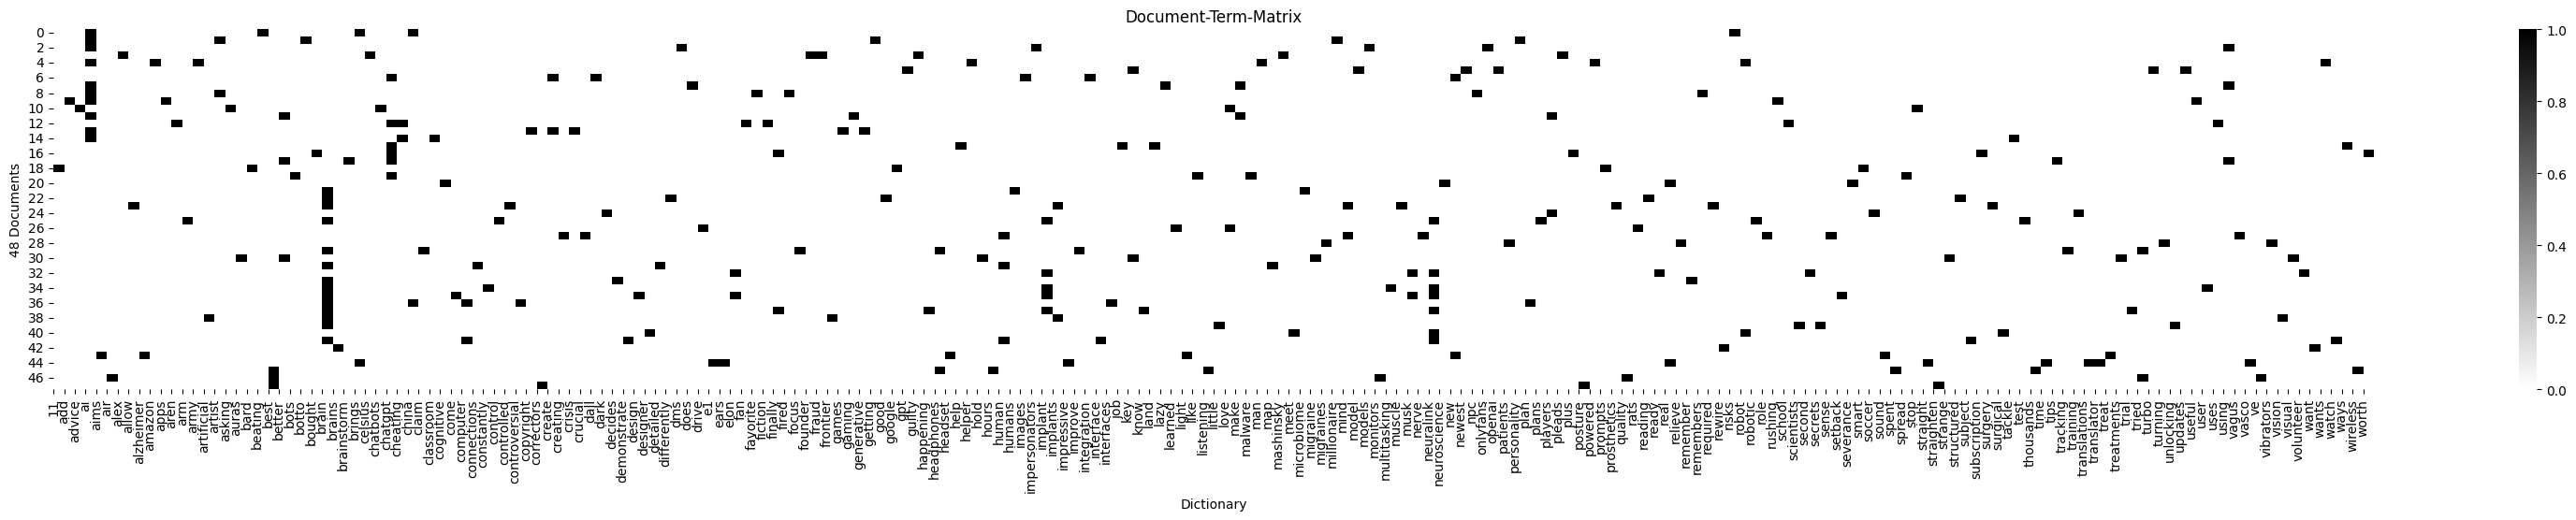

In [8]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.heatmap(
    X_train.todense(),
    ax=ax,
    cmap='gray_r',
)
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)
ax.set_xlabel('Dictionary')
ax.set_ylabel(f'{X_train.shape[0]} Documents')
ax.set_title('Document-Term-Matrix')
plt.show()

You can also fit a ``TfidfVectorizer`` to see how the BoW vectors change.

## Document Classification <a name="classification"></a>

<img src="https://www.nltk.org/images/supervised-classification.png" style="width: 400px;"/>

[Back to top](#toc)

Now, train a document classifier on the article texts to predict the article category (topic). 

- Use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to extract the features of the article headers.
- Use the MinDist classifier to predict the topics. Remember that in scikit-learn, the classifier is called [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html?highlight=nearest%20centroid#sklearn.neighbors.NearestCentroid) classifier. Experiment with cosine distance instead of Euclidean distance.
<div class="alert alert-block alert-warning">
        <strong>Please note:</strong> While cosine distance is an intuitive similarity measure in high dimensional data spaces, its usage as a distance metric for <tt>NearestCentroid</tt> was deprecated in scikit-learn version 1.3 and removed in version 1.5.<br>You can decide for yourself if you'd like to downgrade your scikit-learn version to be able to use cosine distance or use other distance metrics (e.g. Manhattan distance) in your experiments.
    </div>
- In order to assess the classifier's performance, use the test dataset provided as ``test_articles.csv`` on Moodle and plot the confusion matrix.

### Training data

In [9]:
def train_classifier(traning_data: pd.DataFrame, labels: pd.DataFrame, metric: str):
    classifier = NearestCentroid(metric=metric)
    classifier.fit(traning_data, labels)
    return classifier

def train_with_KNN(traning_data: pd.DataFrame, labels: pd.DataFrame, metric: str):
    classifier = KNeighborsClassifier(metric=metric)
    classifier.fit(traning_data, labels)
    return classifier

### Read test_articles and test it

In [10]:
def test_new_data(classifier, test_data_file: str):
    df_test = pd.read_csv(test_data_file, sep=';')

    test_headers = df_test['header']
    test_labels = df_test['topic']

    x_test = vectorizer.transform(test_headers)

    # predict the labels of the test data
    predicted_labels = classifier.predict(x_test)

    # check the accuracy of the model
    accuracy = (predicted_labels == test_labels)

    df_test['predicted_topic'] = predicted_labels
    df_test['is_correct'] = None
    df_test['is_correct'] = df_test['predicted_topic'] == df_test['topic']

    return df_test, accuracy

def display_classifier_info(df_test: pd.DataFrame, accuracy: float):
    display(df_test.head())
    print(f'Accuracy: {accuracy.mean()}')

def plot_confusion_matrix(result_dataframe: pd.DataFrame, ax: plt.Axes, metric: str):
    cm = confusion_matrix(result_dataframe['topic'], result_dataframe['predicted_topic'])
    if ax is None:
        fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        linewidths=1,
        linecolor='black',
    )
    ax.set_xlabel('Predicted topic')
    ax.set_ylabel('True topic')
    ax.set_title(f'Confusion Matrix with metric : {metric}')
    return ax

Training classifier with metric: euclidean


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.4
------------------------------

Training classifier with metric: manhattan


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,artificial-intelligence,True
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,artificial-intelligence,True
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,artificial-intelligence,True
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",artificial-intelligence,True
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.7
------------------------------



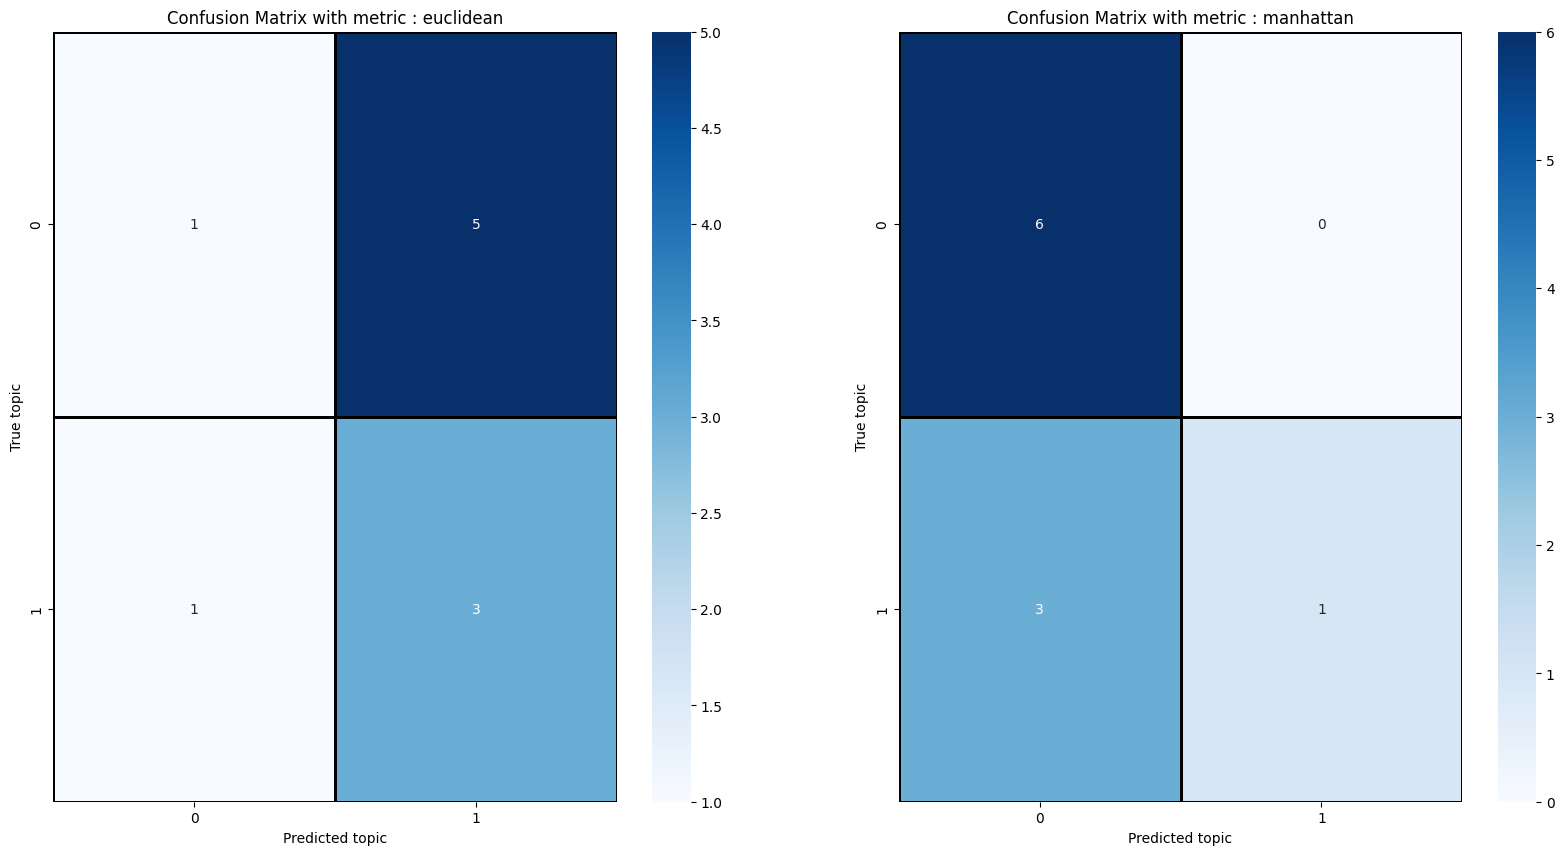

In [11]:
metrics = ['euclidean', 'manhattan']

figure, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()

for index, metric in enumerate(metrics):
    print(f'Training classifier with metric: {metric}')
    classifier = train_classifier(X_train, df['topic'], metric)
    df_test, accuracy = test_new_data(classifier, 'test_articles.csv')
    display_classifier_info(df_test, accuracy)
    plot_confusion_matrix(df_test, axes[index], metric)

    print('---' * 10)
    print()

plt.show()

Training classifier with metric: euclidean


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.6
------------------------------

Training classifier with metric: manhattan


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.6
------------------------------

Training classifier with metric: cosine


,topic,link,header,article,predicted_topic,is_correct
0,artificial-intelligence,/article/game-of-thrones-season-8-predictions,Who will die in Game of Thrones season 8? Scie...,Daenerys has a one per cent chance of death; A...,neuroscience,False
1,artificial-intelligence,/article/artificial-intelligence-extended-inte...,"Forget about artificial intelligence, extended...",We should challenge the cult of Singularity. A...,neuroscience,False
2,artificial-intelligence,/article/marcus-du-sautoy-book-extract-creativ...,What's the purpose of humanity if machines can...,Flashes of inspiration are considered a human ...,neuroscience,False
3,artificial-intelligence,/article/avoid-facial-recognition-software,How to hack your face to dodge the rise of fac...,"Use of facial recognition tech is on the rise,...",neuroscience,False
4,artificial-intelligence,/article/deepmind-ai-chess,DeepMind’s superhuman AI is rewriting how we p...,AlphaZero doesn’t play chess like a machine – ...,artificial-intelligence,True


Accuracy: 0.5
------------------------------



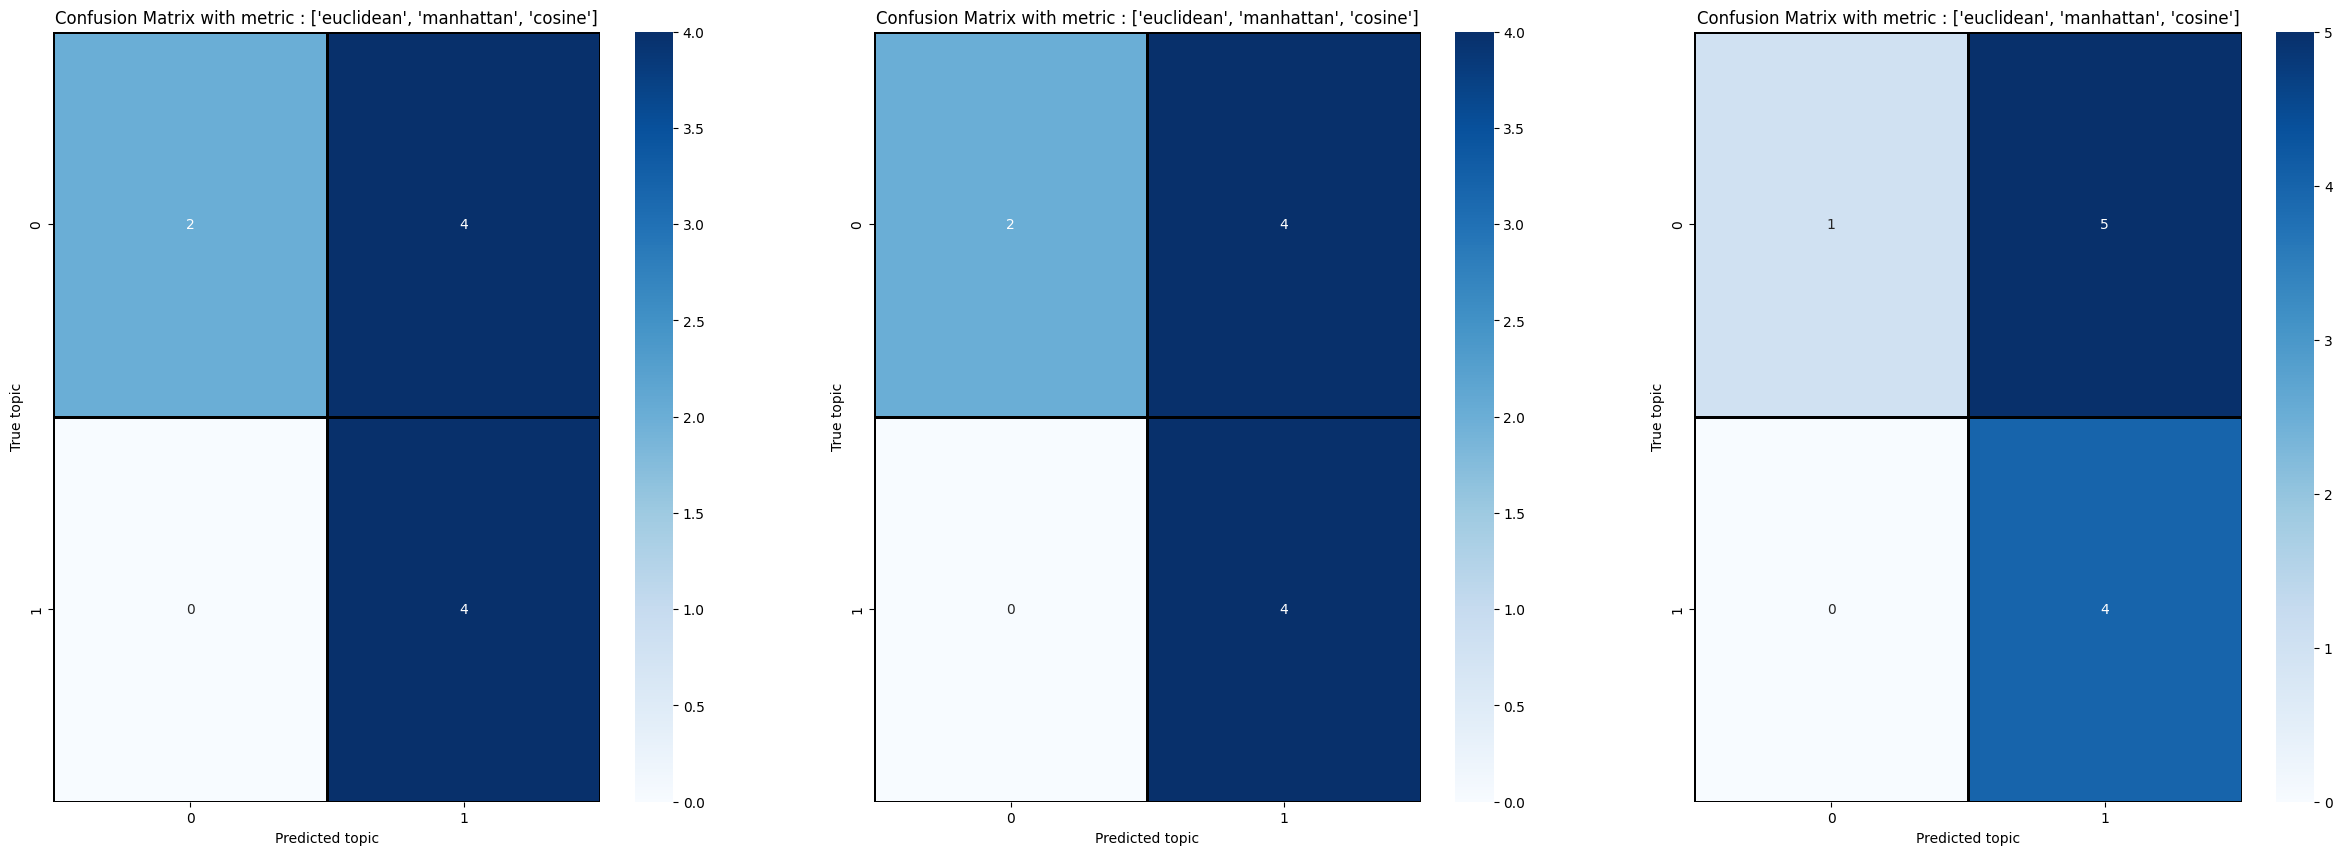

In [12]:
knn_metrics = ['euclidean', 'manhattan', 'cosine']

figure, axes = plt.subplots(1, 3, figsize=(30, 10))
axes = axes.flatten()

for index, metric in enumerate(knn_metrics):
    print(f'Training classifier with metric: {metric}')
    classifier = train_with_KNN(X_train, df['topic'], metric)
    df_test, accuracy = test_new_data(classifier, 'test_articles.csv')
    display_classifier_info(df_test, accuracy)
    plot_confusion_matrix(df_test, axes[index], knn_metrics)

    print('---' * 10)
    print()

plt.show()

## Homework Assignment

Extend your code to include the following:
1. Add a third topic of your choice to the link list DataFrame. 
2. Access the website of each link in your list and extract the article text. Store it in a new columns in your DataFrame. (Make sure to be polite! Add ``time.sleep(...)`` before accessing the next page.)
3. Set aside a small percentage of the dataset you created (~ten percent) to be used for testing later on.
4. Set up a grid search for at least three different parameters of the vectorizer.
5. Evaluate the grid with 5-fold cross validation to find the best hyperparameters for vectorizer and classifier concerning <b>F1 score</b> when trained on the full article texts.
6. Plot the confusion matrix for the test dataset you created in Step 3.


## Moodle Upload
Upload your notebook as ``firstname_lastname_nlp.html`` to Moodle. Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code (such as plotting the document-term-matrix, experimenting with the properties and methods of the CountVectorizer, ...)
* Print the head of your final DataFrame (containing article texts) once.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * describe and interpret your grid settings and justify your choices
    * analyze the final/best results

# HOMEWORK

In [13]:
# minimal document frequency, maximal document frequency, amount of words from document (top 100 words as vocabulary)
# maybe apply stemmer

# UFLL TEXT OF THE ARTICLES -> to do this so have to make a one big dataframe withh all of the words from the articles
# do the classification on uploaded notebook and on the wrods from articles
# implement stemming / lemmatization / parametrizing Vectorizer

# do the homework

In [33]:
# Code snippets that works for techcrunch
def build_dataset(seed_url):
    articles = {
        'topic': [],
        'link': [],
        'header': [],
        'text': [],
    }
    data = requests.get(seed_url)
    time.sleep(1) # sleeping for 1 second to make sure we are polite!
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )
    candidates = soup.find_all(
        "a",
        class_=[
            "loop-card__title-link",
        ],
    )
    for article in candidates:
        articles['topic'].append(seed_url.split('/')[-1])
        articles['link'].append(article['href'])
        articles['header'].append(article.get_text().strip())
        articles['text'].append("")

    return pd.DataFrame(articles)

In [34]:
selected_topics = ['artificial-intelligence', 'security', 'media-entertainment']
dfs = []

seed_url = 'https://techcrunch.com/category/'
# We only want to crawl the web if absolutely necessary, so we check first if we already have an article_headers.csv in our directory
if os.path.exists('article_headers_tech_crunch.csv'):
    df = pd.read_csv(
        'article_headers_tech_crunch.csv',
        sep='\t',
    )
    print('read articles from file')
else:
    print('crawling articles from web...')
    # Crawl and parse the AI page
    for index, topic in enumerate(selected_topics):
        df = build_dataset(seed_url + topic)
        dfs.append(df)

    df = pd.concat(
        dfs,
        ignore_index=True,
    )

    df.to_csv(
        'article_headers_tech_crunch.csv',
        sep='\t',
        index=False,
    )

crawling articles from web...


In [35]:
display(df.head())
display(df.tail())

,topic,link,header,text
0,artificial-intelligence,https://techcrunch.com/2025/02/04/softbank-bac...,SoftBank-backed billionaire to invest $230M in...,
1,artificial-intelligence,https://techcrunch.com/2025/02/04/google-and-d...,"AI agents for e-commerce startup, founded by G...",
2,artificial-intelligence,https://techcrunch.com/2025/02/03/neuralk-ai-i...,Neuralk-AI is developing AI models specificall...,
3,artificial-intelligence,https://techcrunch.com/2025/02/03/accel-backs-...,Accel backs Indian AI startup building ‘ChatGP...,
4,artificial-intelligence,https://techcrunch.com/2025/02/03/naver-backed...,Naver-backed Cinamon wants to make 3D video an...,


,topic,link,header,text
106,media-entertainment,https://techcrunch.com/2025/02/03/heros-all-in...,"Hero’s all-in-one, AI productivity app takes o...",
107,media-entertainment,https://techcrunch.com/2025/02/02/deepseek-fou...,DeepSeek founder Liang Wenfeng receives a hero...,
108,media-entertainment,https://techcrunch.com/2025/02/02/openai-unvei...,OpenAI unveils a new ChatGPT agent for ‘deep r...,
109,media-entertainment,https://techcrunch.com/2025/02/02/dub-the-copy...,Dub: The copy trading app that has teens talking,
110,media-entertainment,https://techcrunch.com/2025/02/01/x-expands-la...,X expands lawsuit over advertiser ‘boycott’ to...,


### Retriving Text from the links

In [ ]:
for index, seed_url in enumerate(df['link']):
    data = requests.get(seed_url)
    time.sleep(1)
    soup = BeautifulSoup(
        data.content.decode('utf-8', 'ignore'),
        'html.parser',
    )

    content = soup.find(
        "div",
        class_=["entry-content"],
    )
    if content: # Check if content exists

        paragraphs = content.find_all('p', class_ = ["wp-block-paragraph"])
        article_text = "".join([p.get_text().strip() for p in paragraphs])
    else:
        article_text = ""

    df.loc[index, 'text'] = article_text



### Check if text was retrived succesfully

In [39]:
display(df.head())
display(df.tail())

,topic,link,header,text
0,artificial-intelligence,https://techcrunch.com/2025/02/04/softbank-bac...,SoftBank-backed billionaire to invest $230M in...,Ola founder Bhavish Aggarwal is investing $230...
1,artificial-intelligence,https://techcrunch.com/2025/02/04/google-and-d...,"AI agents for e-commerce startup, founded by G...","AI is changing how we shop online, making our ..."
2,artificial-intelligence,https://techcrunch.com/2025/02/03/neuralk-ai-i...,Neuralk-AI is developing AI models specificall...,Tabular data is a broad term that encompasses ...
3,artificial-intelligence,https://techcrunch.com/2025/02/03/accel-backs-...,Accel backs Indian AI startup building ‘ChatGP...,"Presentations.ai, an Indian startup that uses ..."
4,artificial-intelligence,https://techcrunch.com/2025/02/03/naver-backed...,Naver-backed Cinamon wants to make 3D video an...,It’s never been easier to create and publish a...


,topic,link,header,text
106,media-entertainment,https://techcrunch.com/2025/02/03/heros-all-in...,"Hero’s all-in-one, AI productivity app takes o...","People often use multiple apps for notes, sche..."
107,media-entertainment,https://techcrunch.com/2025/02/02/deepseek-fou...,DeepSeek founder Liang Wenfeng receives a hero...,DeepSeek founder Liang Wenfeng is being hailed...
108,media-entertainment,https://techcrunch.com/2025/02/02/openai-unvei...,OpenAI unveils a new ChatGPT agent for ‘deep r...,OpenAI is announcing a new AI “agent” designed...
109,media-entertainment,https://techcrunch.com/2025/02/02/dub-the-copy...,Dub: The copy trading app that has teens talking,"Social media changed everything, from news con..."
110,media-entertainment,https://techcrunch.com/2025/02/01/x-expands-la...,X expands lawsuit over advertiser ‘boycott’ to...,X is now suing more advertisers in an antitrus...


### Splitting the data in test and train sets

In [82]:
train_text, test_text, train_topics, test_topics = train_test_split(
    df['text'],
    df['topic'],
    test_size=0.1,
    random_state=42,
)

In [84]:
print(train_topics)

0      artificial-intelligence
81         media-entertainment
18     artificial-intelligence
70                    security
56                    security
                ...           
106        media-entertainment
14     artificial-intelligence
92         media-entertainment
51                    security
102        media-entertainment
Name: topic, Length: 99, dtype: object


### Grid Search

In [95]:
vec = CountVectorizer(stop_words='english')

english_stop_words = vec.get_stop_words()


frozenset({'still', 'yours', 'even', 'therefore', 'thin', 'anyway', 'mill', 'except', 'name', 'her', 'latterly', 'well', 'everything', 'detail', 'seem', 'else', 'fill', 'wherever', 'six', 'myself', 'alone', 'so', 'or', 'i', 'at', 'thereby', 'hereby', 'you', 'cant', 'move', 'herein', 'ten', 'all', 'am', 'eg', 'front', 'across', 'which', 'done', 'not', 'such', 'sixty', 'seems', 'was', 'each', 'elsewhere', 'formerly', 'side', 'ever', 'whereby', 'three', 'via', 'mostly', 'both', 'our', 'get', 'yet', 'nowhere', 'himself', 'in', 'un', 'hasnt', 'ours', 'only', 'no', 'sincere', 'namely', 'been', 'why', 'had', 'another', 'towards', 'be', 'serious', 'more', 'fifty', 'here', 'nine', 'off', 'thence', 'he', 'call', 'most', 'amongst', 'without', 'thereupon', 'eleven', 'always', 'itself', 'put', 'none', 'describe', 'noone', 'keep', 'latter', 'thick', 'whereas', 'per', 'my', 'how', 'hereafter', 'hers', 'between', 'but', 'enough', 'twenty', 'after', 'other', 'one', 'two', 'take', 'when', 'may', 'the', 

In [ ]:
# custom preprocessor to get rid of verything that starts with a number
def custom_preprocessor(text):
    return ' '.join([word for word in text.split() if not re.match(r'^\d', word)])

vec = CountVectorizer()


stop_words = ['english', None]
max_features = [100, 500, 1000, 2000]
max_df = [0.5, 0.75, 1.0]
min_df = [1, 2, 3, 5]
preprocessor = [None, custom_preprocessor]

classifier = KNeighborsClassifier(metric='manhattan')

pipe = Pipeline([
    ('vec', vec),
    ('classifier', classifier)])

param_grid = {
    'vec__stop_words': stop_words,
    'vec__max_features': max_features,
    'vec__max_df': max_df,
    'vec__min_df': min_df,
    'vec__preprocessor': preprocessor,}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
)

grid_search.fit(train_text, train_topics)

print("Best parameters : ", grid_search.best_params_)
print("Best F1 score : ", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters :  {'vec__max_df': 0.75, 'vec__max_features': 100, 'vec__min_df': 3, 'vec__stop_words': None}
Best F1 score :  0.5598746027748798
